# ICON-XPP data

```{note}
The online laboratory has only been tested in recent Firefox and Chrome browsers. Some features may not (yet) be supported in Safari browsers.
```

```{caution}
In the online laboratory, changes to notebooks and local files are only saved in your web browser's storage and not persisted to disk.

Please download copies of any files that you don't want to loose.

Your files from an old session will usually be kept if you close or refresh this page, unless your browser's storage for `lab.climet.eu` is cleared, e.g.
- manually by clearing the browser's site data
- automatically when too much data is stored
- automatically when you close a private browsing context
- if you have setup your browser to clear site data, e.g. when the browser is closed
```

This notebook is a comprehensive guide to accessing NetCDF files for an ICON-eXtendedPrediction and Projection (XPP) simulation. It includes details about the available parameters and steps, along with instructions for using the `load_ICONXPP_data` function to access these files from the [ECMWF S3 bucket](https://object-store.os-api.cci1.ecmwf.int/esiwacebucket/ICON-XPP/). The NetCDF files are not downloaded locally; instead, they are accessed remotely using `kerchunk` and `zarr` via their corresponding `.ref` metadata files (also hosted in the S3 bucket), which were produced up-front using `kerchunk`.

---

## Experiment Details and Available Data Fields

The dataset consists of output data from an ICON-XPP run, a current state-of-the-art climate-scale simulation.
The simulation was conducted using a horizontal grid spacings of about 80km (ICON grid R2B5).
A global, coupled simulation covering a time period of 1000 years, starting in 1300, was run. Monthly output data was generated throughout the simulation. 
The total volume of the available dataset is about 147 GB. The data are available under the BSD-3-Clause license <https://opensource.org/license/bsd-3-clause>.

The dataset is organized into multiple NetCDF files, with each file containing five years of simulation output along with all available parameters.

The following 2D parameters are available:
```python
[
    "pres_msl", "pres_sfc", "t_s", "clct", "tot_prec_rate", "tqv", "tqv_dia",
    "tqc_dia", "tqi_dia", "umfl_s", "vmfl_s", "sp_10m", "t_2m", "sob_t",
    "sod_t", "sou_t", "thb_t", "sob_s", "sou_s", "thb_s", "shfl_s", "lhfl_s",
    "snow_con_rate", "snow_gsp_rate", "ice_gsp_rate", "qifl_s", "qhfl_s",
    "t_seasfc", "fr_land", "fr_seaice", "condhf_ice", "meltpot_ice", "t_ice",
    "h_ice", "albvisdif", "albvisdir", "albnirdif", "albnirdir",
]
```

The available time steps begin at 1300-02-01 00:00:00 UTC, increasing in 1-month steps until 2300-01-01 00:00:00 UTC.

## Using the `load_ICONXPP_data` Function

To load the NetCDF files, you can use the following function:

```python
load_ICONXPP_data(year=None, month=None)
```

### Parameters

- **`year`**: An integer specifying the year for which data should be loaded. Available years: 1300 to 2300.
- **`month`**(optional): An integer specifying the month for which data should be loaded.

The datasets start on February 1st for years ending in `00` or `05`. If you need data for January 1st of these years, be sure to specify the appropriate month to load the correct dataset.


In [1]:
# URL of S3 bucket
BASE_URL = "https://object-store.os-api.cci1.ecmwf.int/esiwacebucket"

First, the package `zarr` (modern dataset format that is specifically designed for chunked access) and its dependencies need to be imported for the remote access.

In [2]:
import aiohttp
import cftime
import dask
import fsspec
import zarr

[pyodide]: Loading PyYAML, aiohappyeyeballs, aiohttp, aiosignal, asciitree, attrs, cftime, click, cloudpickle, dask, frozenlist, fsspec, locket, multidict, numcodecs, numpy, partd, propcache, toolz, yarl, zarr
[pyodide]: Loaded PyYAML, aiohappyeyeballs, aiohttp, aiosignal, asciitree, attrs, cftime, click, cloudpickle, dask, frozenlist, fsspec, locket, multidict, numcodecs, numpy, partd, propcache, toolz, yarl, zarr
[pyodide]: Loading Jinja2, MarkupSafe
[pyodide]: Loaded Jinja2, MarkupSafe
[pyodide]: Loading lz4
[pyodide]: Loaded lz4
[pyodide]: Loading msgpack
[pyodide]: Loaded msgpack
[pyodide]: Memory usage has grown to 71.9MiB (from 49.9MiB) for this notebook
[pyodide]: Loaded 35 new dynamic libraries (41 total for this notebook)


The `load_ICONXPP_data` function simplifies remote access to NetCDF datasets stored on the S3 bucket. It validates input parameters, constructs the correct URL for the requested data, and loads it efficiently as an xarray dataset using the corresponding `.ref` file.


In [3]:
import json

import numpy as np
import requests
import xarray as xr


def load_ICONXPP_data(year=None, month=None):
    if not isinstance(year, int) or year < 1300 or year > 2300:
        raise ValueError("Please specify a valid year as an integer between 1300 and 2300.")

    if year == 2300:
        if not month:
            print(f"Warning: Only data for January 1st are available for 2300.")
        if month and month != 1:
            raise ValueError(f"Only data for January 1st are available for 2300.")
            
    if month:
        if not isinstance(month, int) or month < 1 or month > 12:
            raise ValueError(f"Please specify a valid month as an integer between 1 and 12.")

    file_year = (year // 10) * 10
    if not year % 10 <= 4: 
        file_year += 5

    if not month and year % 5 == 0:
        if year == 1300:
            print(f"Warning: Data for January 1st of 1300 are not available as is is the simulation starting time.")
        else:
            print(f"Warning: Data for January 1st of '{year}' are stored in the previous file. Please specify the month to load the correct dataset.")
    elif month == 1 and year % 5 == 0:
        if year == 1300:
            raise ValueError(f"Data for January 1st of 1300 are not available as this is the simulation starting time.")
        file_year -= 5
        
    if year == 2300:
        file_year = 2295

    url = f"{BASE_URL}/ICON-XPP/slo1802_atm_2d_ml_{file_year}0101T000000Z.nc"
        
    ref = requests.get(f"{url}.ref").json()

    print(f"Loading dataset {url}")

    ds = xr.open_dataset(
        "reference://", 
        engine="zarr", 
        backend_kwargs={"storage_options": {"fo": ref}},
        consolidated=False, 
        chunks=dict(),
    )
    ds.clon.values=np.degrees(ds.clon.values)
    ds.clat.values=np.degrees(ds.clat.values)
    
    return ds

[pyodide]: Loading pandas, python-dateutil, pytz, six, tzdata, xarray
[pyodide]: Loaded pandas, python-dateutil, pytz, six, tzdata, xarray
[pyodide]: Loading pyarrow, pyodide-unix-timezones
[pyodide]: Loaded pyarrow, pyodide-unix-timezones
[pyodide]: Memory usage has grown to 124.2MiB (from 71.9MiB) for this notebook
[pyodide]: Loaded 45 new dynamic libraries (86 total for this notebook)


## Example Usage

To load NetCDF file for pressure level parameters, you can use the following example. This will load the data for years 2020 to 2025. 

In [4]:
ds_2020 = load_ICONXPP_data(year=2024)
ds_2020

Loading dataset https://object-store.os-api.cci1.ecmwf.int/esiwacebucket/ICON-XPP/slo1802_atm_2d_ml_20200101T000000Z.nc
[pyodide]: Loading netCDF4
[pyodide]: Loaded netCDF4
[pyodide]: Loading h5netcdf, h5py
[pyodide]: Loaded h5netcdf, h5py
[pyodide]: Loading scipy
[pyodide]: Loaded scipy
[pyodide]: Loading ujson
[pyodide]: Loaded ujson
[pyodide]: Loading Pint, flexcache, flexparser, platformdirs, typing_extensions
[pyodide]: Loaded Pint, flexcache, flexparser, platformdirs, typing_extensions
[pyodide]: Loading future, uncertainties
[pyodide]: Loaded future, uncertainties


<xarray.Dataset> Size: 733MB
Dimensions:        (time: 60, ncells: 81920, vertices: 3, height: 1, height_2: 1)
Coordinates:
    clat           (ncells) float64 655kB 89.46 88.64 89.06 ... -27.32 -27.0
    clon           (ncells) float64 655kB 72.0 50.25 72.0 ... 1.296 0.6204 0.357
  * height         (height) float64 8B 10.0
  * height_2       (height_2) float64 8B 2.0
  * time           (time) datetime64[ns] 480B 2020-02-01 ... 2025-01-01
Dimensions without coordinates: ncells, vertices
Data variables: (12/40)
    albnirdif      (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    albnirdir      (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    albvisdif      (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    albvisdir      (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    clat_bnds      (ncells, vertices) float64 2MB dask.array<chunksize=(81920, 3), meta=np.ndarray>
    clct           (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    ...             ...
    tqc_dia        (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    tqi_dia        (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    tqv            (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    tqv_dia        (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    umfl_s         (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    vmfl_s         (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 2.4.0 (https://mpime...
    Conventions:          CF-1.6
    comment:              Stephan Lorenz (m211032) on l20308 (Linux 4.18.0-47...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/ic...
    history:              /work/mh0287/m211032/Icon/Git_lev/icon.XPP.20240717...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  30
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-mpim.git@fba959455f42c...
    title:                ICON simulation
    uuidOfHGrid:          a668eac0-fe2e-11e4-9a47-e3e5371a87a7

[pyodide]: Memory usage has grown to 149.1MiB (from 124.2MiB) for this notebook
[pyodide]: Loaded 38 new dynamic libraries (124 total for this notebook)


The `earthkit` package is used for plotting the data.

In [5]:
import earthkit.plots
import earthkit.plots.quickmap

[pyodide]: Loading Cartopy, Markdown, adjustText, affine, array_api_compat, cffi, cfgrib, click-plugins, cligj, contourpy, cycler, earthkit, earthkit-data, earthkit-geo, earthkit-meteo, earthkit-plots, earthkit-plots-default-styles, earthkit-regrid, earthkit-time, earthkit-transforms, eccodes, entrypoints, filelock, findlibs, fonttools, geopandas, jsonschema, jsonschema-specifications, kiwisolver, lru-dict, matplotlib, matplotlib-pyodide, multiurl, pdbufr, pillow, plotly, pycparser, pyogrio, pyparsing, pyproj, pyshp, rasterio, referencing, rpds-py, shapely, tenacity, tqdm
[pyodide]: Loaded Cartopy, Markdown, adjustText, affine, array_api_compat, cffi, cfgrib, click-plugins, cligj, contourpy, cycler, earthkit, earthkit-data, earthkit-geo, earthkit-meteo, earthkit-plots, earthkit-plots-default-styles, earthkit-regrid, earthkit-time, earthkit-transforms, eccodes, entrypoints, filelock, findlibs, fonttools, geopandas, jsonschema, jsonschema-specifications, kiwisolver, lru-dict, matplotlib,

Matplotlib is building the font cache; this may take a moment.


[pyodide]: Loading fiona
[pyodide]: Loaded fiona
[pyodide]: Loading ipywidgets, jupyterlab_widgets, widgetsnbextension
[pyodide]: Loaded ipywidgets, jupyterlab_widgets, widgetsnbextension


/lib/python3.12/site-packages/earthkit/regrid/utils/caching.py:27: UserWarning: only soft file lock is available
  from filelock import FileLock


[pyodide]: Memory usage has grown to 257.8MiB (from 149.1MiB) for this notebook
[pyodide]: Loaded 60 new dynamic libraries (184 total for this notebook)


The data can be visualized as demonstrated below. For example, the 2 metre temperature on **2024-12-01 at 00:00:00 UTC** is plotted.


/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


[pyodide]: Memory usage has grown to 534.6MiB (from 257.8MiB) for this notebook
[pyodide]: Loaded 1 new dynamic library (185 total for this notebook)


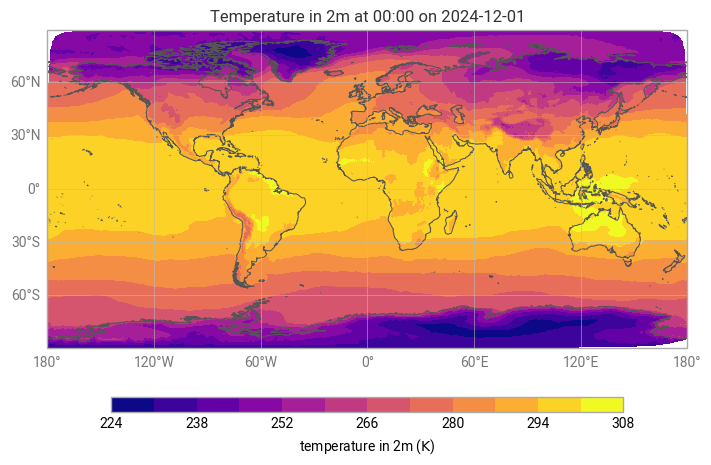

In [6]:
earthkit.plots.quickmap.plot(
    ds_2020["t_2m"].sel(time="2024-12-01 00:00:00"), 
    x="clon", y="clat"
);

If interested in data on **2020-01-01 at 00:00:00 UTC** the previous NetCDF file needs to be loaded. This will automatically be done by specifying the month as well.

In [7]:
ds_2015 = load_ICONXPP_data(year=2020, month=1)
ds_2015

Loading dataset https://object-store.os-api.cci1.ecmwf.int/esiwacebucket/ICON-XPP/slo1802_atm_2d_ml_20150101T000000Z.nc


<xarray.Dataset> Size: 733MB
Dimensions:        (time: 60, ncells: 81920, vertices: 3, height: 1, height_2: 1)
Coordinates:
    clat           (ncells) float64 655kB 89.46 88.64 89.06 ... -27.32 -27.0
    clon           (ncells) float64 655kB 72.0 50.25 72.0 ... 1.296 0.6204 0.357
  * height         (height) float64 8B 10.0
  * height_2       (height_2) float64 8B 2.0
  * time           (time) datetime64[ns] 480B 2015-02-01 ... 2020-01-01
Dimensions without coordinates: ncells, vertices
Data variables: (12/40)
    albnirdif      (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    albnirdir      (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    albvisdif      (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    albvisdir      (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    clat_bnds      (ncells, vertices) float64 2MB dask.array<chunksize=(81920, 3), meta=np.ndarray>
    clct           (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    ...             ...
    tqc_dia        (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    tqi_dia        (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    tqv            (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    tqv_dia        (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    umfl_s         (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
    vmfl_s         (time, ncells) float32 20MB dask.array<chunksize=(1, 81920), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 2.4.0 (https://mpime...
    Conventions:          CF-1.6
    comment:              Stephan Lorenz (m211032) on l20308 (Linux 4.18.0-47...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/ic...
    history:              /work/mh0287/m211032/Icon/Git_lev/icon.XPP.20240717...
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  30
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-mpim.git@fba959455f42c...
    title:                ICON simulation
    uuidOfHGrid:          a668eac0-fe2e-11e4-9a47-e3e5371a87a7

[pyodide]: Loaded 1 new dynamic library (186 total for this notebook)


The data can be visualized as demonstrated below. For example, the total precipitation rate on **2020-01-01 at 00:00:00 UTC** is plotted.

[pyodide]: Memory usage has grown to 733.0MiB (from 534.6MiB) for this notebook


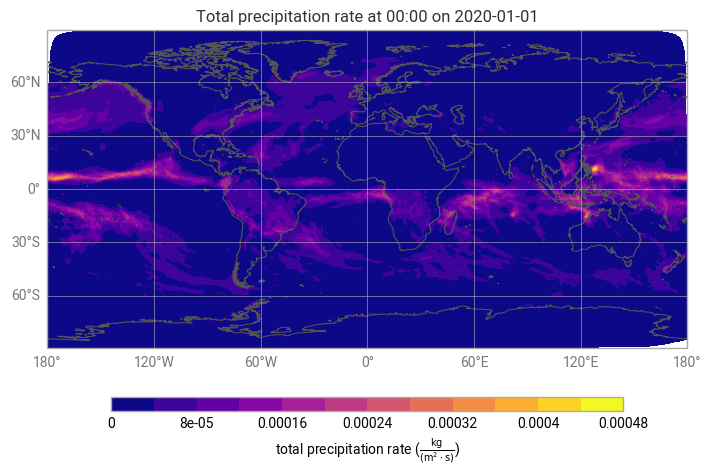

In [8]:
earthkit.plots.quickmap.plot(
    ds_2015["tot_prec_rate"].sel(time="2020-01-01 00:00:00"), 
    x="clon", y="clat"
);

Please note: The `earthkit-plots` does currently not yet support plotting data outside of years 1678 to 2262.